**Measuring the Exposure to Air Pollution for Pedestrians in Boston Metropolitan Area and its Relation to Walkability**

**Links to the datasets:** <br>
(i) https://www.mass.gov/info-details/massgis-data-2010-us-census <br>
(ii) https://www.epa.gov/smartgrowth/smart-location-mapping#SLD <br>
(iii) https://www.epa.gov/healthresearch/community-line-source-model-c-line-estimate-roadway-emissions#:~:text=What%20is%20the%20Community%2DLINE,fleet%20mix%20and%20vehicle%20speed

**Final Project | UEP238 | Spring 2023 | Tufts University**<br>
**Members:** Patrali Ghosh and Vishwesh Srinivasan

In [1]:
# all the required libraries are imported here
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pysal
import spreg
import libpysal

#### Data Cleaning ####

Preparing the shapefiles (10m x 10m grid) downloaded from C-LINE tool having the NOx concentrations (ppb) for the Greater Boston Region for analysis. These files were downloaded and provided by Hongkun Huang (Hongkun.Huang@tufts.edu) 

In [2]:
# list of all directories having the shapefiles of the above dataset
directories = ['./Air quality files/', './Air quality files/missing_parts_I', './Air quality files/missing_parts_II']

In [3]:
# an empty list
gdf_list = []

In [4]:
# reading in all the shapefiles sequentially present in the above directories and adding it to the empty list created above
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith('.shp'):
            filepath = os.path.join(directory, filename)
            gdf = gpd.read_file(filepath)
            gdf_list.append(gdf)

In [5]:
# converting the list to a geopandas dataframe and viewing the first few records
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf.crs)
combined_gdf.head()

,NAME,STATE_NAME,POLLUTANT,UNITS,AREA_CONC,POINT_CONC,RAIL_CONC,ROAD_CONC,SHIP_CONC,TOTAL_CONC,geometry
0,250235051011 (partial),Massachusetts,NOx,concentration (ppb),NaN,NaN,NaN,0.027386,NaN,0.027386,"POLYGON ((-70.78336 42.23752, -70.78377 42.237..."
1,250214231001 (partial),Massachusetts,NOx,concentration (ppb),NaN,NaN,NaN,0.008951,NaN,0.008951,"POLYGON ((-70.79010 42.25446, -70.78872 42.253..."
2,250214012003 (partial),Massachusetts,NOx,concentration (ppb),NaN,NaN,NaN,4.036950,NaN,4.036950,"POLYGON ((-71.15151 42.29950, -71.15030 42.295..."
3,250250923003 (partial),Massachusetts,NOx,concentration (ppb),NaN,NaN,NaN,0.715597,NaN,0.715597,"POLYGON ((-71.07829 42.29312, -71.07848 42.294..."
4,250250924004,Massachusetts,NOx,concentration (ppb),NaN,NaN,NaN,1.936966,NaN,1.936966,"POLYGON ((-71.08938 42.29376, -71.08978 42.292..."


In [6]:
# subsetting the above geopandas dataframe to the columns required and viewing the first few records
combined_gdf = combined_gdf[['NAME', 'TOTAL_CONC']]
combined_gdf.head()

,NAME,TOTAL_CONC
0,250235051011 (partial),0.027386
1,250214231001 (partial),0.008951
2,250214012003 (partial),4.036950
3,250250923003 (partial),0.715597
4,250250924004,1.936966


In [7]:
# removing duplicate whole Census Block Groups (CBGs) and combining partial Census Block Groups (CBGs).

# isolating the CBGs without '(partial)' string in them.
no_partial = combined_gdf[~combined_gdf['NAME'].str.contains('\(partial\)')]

# removing duplicates from the above isolated CBGs (this removes duplicates from the CBGs which are whole).
no_partial = no_partial.drop_duplicates(subset='NAME')

# isolating the CBGs with '(partial)' string in them.
partial = combined_gdf[combined_gdf['NAME'].str.contains('\(partial\)')]

# combining the no_partial (without duplicates) and partial dataframes
combined_gdf = pd.concat([no_partial, partial], ignore_index=True)

# removing the string '(partial)' from the CBGs
combined_gdf['NAME'] = combined_gdf['NAME'].str.replace(' \(partial\)', '', regex = True)
combined_gdf['NAME'] = combined_gdf['NAME'].str.strip()

# grouping by CBGs (this combines all the partial CBGs) and taking the average of the NOx concentrations
combined_gdf = combined_gdf.groupby('NAME').mean().reset_index()

# renaming the CBG's NAME to GEOID10 and viewing all the records
combined_gdf = combined_gdf.rename(columns={'NAME': 'GEOID10'})
combined_gdf.head()

,GEOID10,TOTAL_CONC
0,250092011001,0.252740
1,250092011002,0.186181
2,250092011003,0.530704
3,250092011004,0.231062
4,250092021011,0.152737


Preparing the 2010 Census Block Groups boundary shapefile downloaded from MassGIS for analysis. The geometry fomr this shapfile is retained finally for visualization purposes.

In [8]:
# reading in the shapefile of the above dataset and viewing the first few records
ma_cbg = gpd.read_file('./MA_census_block_groups/CENSUS2010BLOCKGROUPS_POLY.shp')
ma_cbg.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,023,525104,2,250235251042,Block Group 2,G5030,2648651.0,119260.0,+41.9751132,...,683.9256,1120,404,0159334,137632,0007882,0137632,2.767760e+06,8963.749528,"POLYGON ((245073.458 857943.957, 244937.535 85..."
1,25,023,525104,4,250235251044,Block Group 4,G5030,4625818.0,11563.0,+41.9677679,...,1145.8539,2178,690,0159336,137634,0007884,0137634,4.637125e+06,9555.602586,"POLYGON ((242521.255 859747.835, 242574.643 85..."
2,25,023,525203,1,250235252031,Block Group 1,G5030,2367037.0,62136.0,+42.0051872,...,600.2231,1540,527,0159338,137636,0007885,0137636,2.429027e+06,9226.194871,"POLYGON ((244276.840 862120.231, 244318.253 86..."
3,25,023,510100,2,250235101002,Block Group 2,G5030,686351.0,0.0,+42.1115078,...,169.5890,1172,414,0159161,137459,0007745,0137459,6.863050e+05,3338.839737,"POLYGON ((241369.452 874137.571, 241375.528 87..."
4,25,023,510100,3,250235101003,Block Group 3,G5030,403906.0,0.0,+42.1115626,...,99.8001,792,290,0159162,137460,0007746,0137460,4.038783e+05,3178.436538,"POLYGON ((240747.746 873189.605, 240726.355 87..."


In [9]:
# subsetting the above geopandas dataframe to the columns required and viewing the first few records
ma_cbg = ma_cbg[['GEOID10','COUNTYFP10','geometry']]
ma_cbg.head()

,GEOID10,COUNTYFP10,geometry
0,250235251042,023,"POLYGON ((245073.458 857943.957, 244937.535 85..."
1,250235251044,023,"POLYGON ((242521.255 859747.835, 242574.643 85..."
2,250235252031,023,"POLYGON ((244276.840 862120.231, 244318.253 86..."
3,250235101002,023,"POLYGON ((241369.452 874137.571, 241375.528 87..."
4,250235101003,023,"POLYGON ((240747.746 873189.605, 240726.355 87..."


In [10]:
# merging this shapefile with the NOx concentrations dataframe on the CBGs ID column 'GEOID10' and viewing the dataframe
merged_gdf = combined_gdf.merge(ma_cbg, on='GEOID10')
merged_gdf

,GEOID10,TOTAL_CONC,COUNTYFP10,geometry
0,250092011001,0.252740,009,"POLYGON ((246381.267 911958.018, 246415.606 91..."
1,250092011002,0.186181,009,"MULTIPOLYGON (((247431.927 908949.847, 247442...."
2,250092011003,0.530704,009,"MULTIPOLYGON (((247128.396 908760.186, 247155...."
3,250092011004,0.231062,009,"POLYGON ((246901.582 908651.584, 246900.118 90..."
4,250092021011,0.152737,009,"POLYGON ((249381.471 915086.470, 249386.783 91..."
...,...,...,...,...
1672,250259815021,0.993568,025,"POLYGON ((240937.374 906105.855, 240928.490 90..."
1673,250259816001,0.389338,025,"MULTIPOLYGON (((241584.134 904794.139, 241601...."
1674,250259817001,6.540177,025,"POLYGON ((235977.052 900615.502, 235967.992 90..."
1675,250259818001,4.203869,025,"POLYGON ((233708.343 899641.764, 233712.572 89..."


Preparing the National Walkability Index shapefile, part of Smart Location Mapping dataset provided by United States EPA for analysis.

In [11]:
# reading in the shapefile of the above dataset and viewing the first few records
ntl_wi = gpd.read_file('./WalkabilityIndex/Natl_WI.shp')
ntl_wi.head()

,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,CBSA_Name,...,D3B,D4A,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Leng,Shape_Area,geometry
0,481130078254,481130078254,48,113,007825,4,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",...,115.981747,362.10,6.0,14.0,15.0,17.0,14.000000,3110.360820,297836.083090,"POLYGON ((-68983.316 1091325.734, -68981.266 1..."
1,481130078252,481130078252,48,113,007825,2,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",...,80.145600,718.84,3.0,10.0,12.0,14.0,10.833333,3519.469110,484945.146563,"POLYGON ((-68891.713 1090955.557, -68860.876 1..."
2,481130078253,481130078253,48,113,007825,3,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",...,24.272717,398.31,1.0,1.0,7.0,17.0,8.333333,1697.091802,106705.928129,"POLYGON ((-68078.320 1091181.799, -68077.077 1..."
3,481130078241,481130078241,48,113,007824,1,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",...,141.604424,386.24,16.0,10.0,17.0,17.0,15.666667,2922.609204,481828.430336,"POLYGON ((-68978.261 1090638.770, -68976.661 1..."
4,481130078242,481130078242,48,113,007824,2,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",...,65.307963,638.37,4.0,7.0,11.0,14.0,10.166667,3731.971773,687684.775181,"POLYGON ((-68980.363 1090202.600, -68965.203 1..."


In [12]:
# subsetting the above geopandas dataframe to the columns required and viewing the first few records
ntl_wi = ntl_wi[['GEOID10', 'D3B', 'D4A', 'D2B_E8MIXA', 'D2A_EPHHM', 'NatWalkInd']]
ntl_wi.head()

,GEOID10,D3B,D4A,D2B_E8MIXA,D2A_EPHHM,NatWalkInd
0,481130078254,115.981747,362.10,0.662091,0.348912,14.000000
1,481130078252,80.145600,718.84,0.554458,0.197047,10.833333
2,481130078253,24.272717,398.31,-0.000000,0.000000,8.333333
3,481130078241,141.604424,386.24,0.553831,0.682830,15.666667
4,481130078242,65.307963,638.37,0.459064,0.261472,10.166667


In [13]:
# merging this shapefile with the above merged dataframe on the CBGs ID column 'GEOID10' and viewing the dataframe
merged_gdf = merged_gdf.merge(ntl_wi, on='GEOID10')
merged_gdf

,GEOID10,TOTAL_CONC,COUNTYFP10,geometry,D3B,D4A,D2B_E8MIXA,D2A_EPHHM,NatWalkInd
0,250092011001,0.252740,009,"POLYGON ((246381.267 911958.018, 246415.606 91...",150.103295,258.84,0.329382,0.509057,14.333333
1,250092011002,0.186181,009,"MULTIPOLYGON (((247431.927 908949.847, 247442....",109.759819,240.06,0.650444,0.245113,14.333333
2,250092011003,0.530704,009,"MULTIPOLYGON (((247128.396 908760.186, 247155....",92.582777,205.19,0.351801,0.410253,13.166667
3,250092011004,0.231062,009,"POLYGON ((246901.582 908651.584, 246900.118 90...",105.458572,205.19,0.552603,0.214093,13.500000
4,250092021011,0.152737,009,"POLYGON ((249381.471 915086.470, 249386.783 91...",79.235448,535.11,0.510901,0.720518,13.333333
...,...,...,...,...,...,...,...,...,...
1672,250259815021,0.993568,025,"POLYGON ((240937.374 906105.855, 240928.490 90...",97.256410,431.84,0.577832,0.746577,14.666667
1673,250259816001,0.389338,025,"MULTIPOLYGON (((241584.134 904794.139, 241601....",44.142494,907.94,0.399212,0.598818,10.500000
1674,250259817001,6.540177,025,"POLYGON ((235977.052 900615.502, 235967.992 90...",1304.568850,219.94,-0.000000,0.000000,13.333333
1675,250259818001,4.203869,025,"POLYGON ((233708.343 899641.764, 233712.572 89...",529.748333,610.21,0.158772,0.167738,12.333333


In [14]:
# converting the merged_gdf back to to a geopandas dataframe after performing all the manipulations for further analysis
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry = 'geometry')

#### Visualizations ####

Visualizing the National Walkability Index and NOx Concentrations (ppb) for the Greater Boston Region

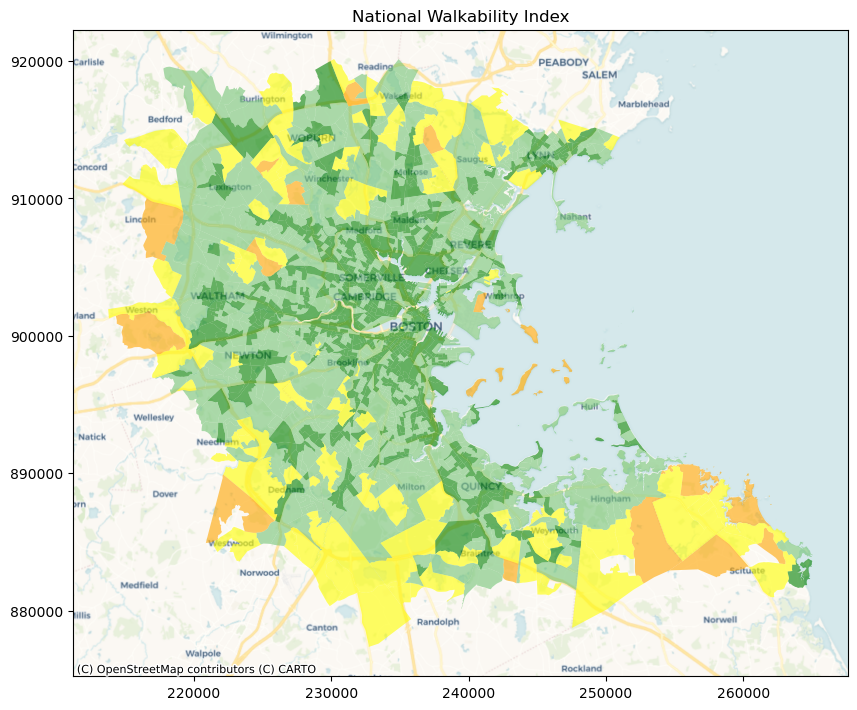

In [15]:
# National Walkability Index Visualization

# defining the categories and their boundaries
categories = ['Least walkable', 'Below average walkable', 'Above average walkable', 'Most walkable']
bounds = [5.75, 10.5, 15.25, 20]

# assigning each feature to a category based on its walkability value
merged_gdf['Walkability Category'] = np.searchsorted(bounds, merged_gdf['NatWalkInd'])

# creating a colormap with a color for each category
colors = ['orange', 'yellow', '#74c476', 'green']
cmap = ListedColormap(colors)

# plotting the map using the new colors and setting the title
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf.plot(column='Walkability Category', cmap=cmap, ax=ax, alpha=0.6)
ax.set_title('National Walkability Index')

# adding basemap using contextily
cx.add_basemap(ax=ax, crs=merged_gdf.crs, source=cx.providers.CartoDB.Voyager)

# saving the plot and displaying it here
plt.savefig('walkability_GBR.png', bbox_inches='tight')
plt.show()

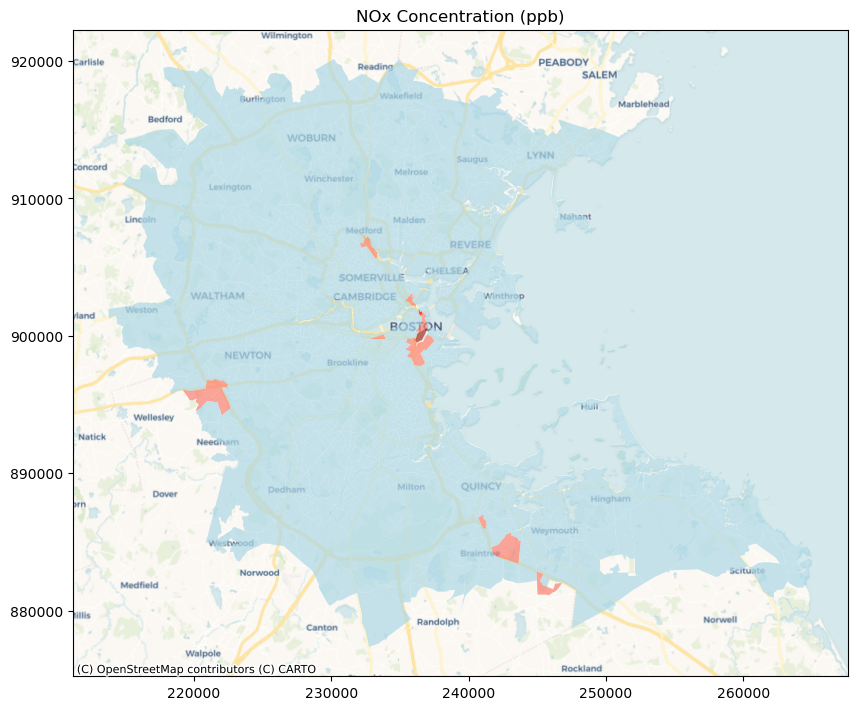

In [16]:
# NOx Concentrations (ppb) Visualization

# defining the categories and their boundaries
categories = ['Very Low', 'Low', 'High', 'Very High']
bounds = [18.75, 37.5, 56.25, 75]

# assigning each feature to a category based on its NOx concentration value
merged_gdf['Pollution Category'] = np.searchsorted(bounds, merged_gdf['TOTAL_CONC'])

# creating a colormap with a color for each category
colors = ['lightblue','salmon','red','brown']
cmap = ListedColormap(colors)

# plotting the map using the new colors and setting the title
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf.plot(column='Pollution Category', cmap=cmap, ax=ax, alpha=0.7)
ax.set_title('NOx Concentration (ppb)')

# adding basemap using contextily
cx.add_basemap(ax=ax, crs=merged_gdf.crs, source=cx.providers.CartoDB.Voyager)

# saving the plot and displaying it here
plt.savefig('pollution_GBR.png', bbox_inches='tight')
plt.show()

Visualizing the National Walkability Index and NOx Concentrations (ppb) for Boston City

In [17]:
# subsetting the geopandas dataframe to only Boston City CBGs by filtering based on the '025' COUNTY code
merged_gdf_boston = merged_gdf[merged_gdf['COUNTYFP10'] == '025']

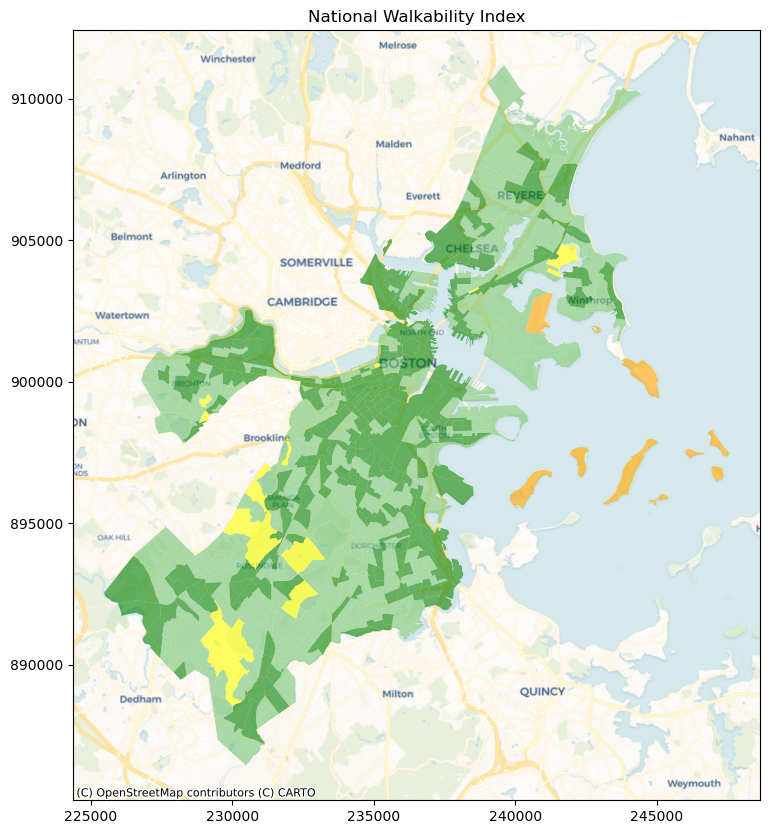

In [18]:
# National Walkability Index Visualization

# creating a colormap with a color for each category
colors = ['orange', 'yellow', '#74c476', 'green']
cmap = ListedColormap(colors)

# plotting the map using the new colors and setting the title
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf_boston.plot(column='Walkability Category', cmap=cmap, ax=ax, alpha = 0.6)
ax.set_title('National Walkability Index')

# adding basemap using contextily
cx.add_basemap(ax=ax, crs=merged_gdf_boston.crs, source=cx.providers.CartoDB.Voyager)

# saving the plot and displaying it here
plt.savefig('walkability_Boston.png', bbox_inches='tight')
plt.show()

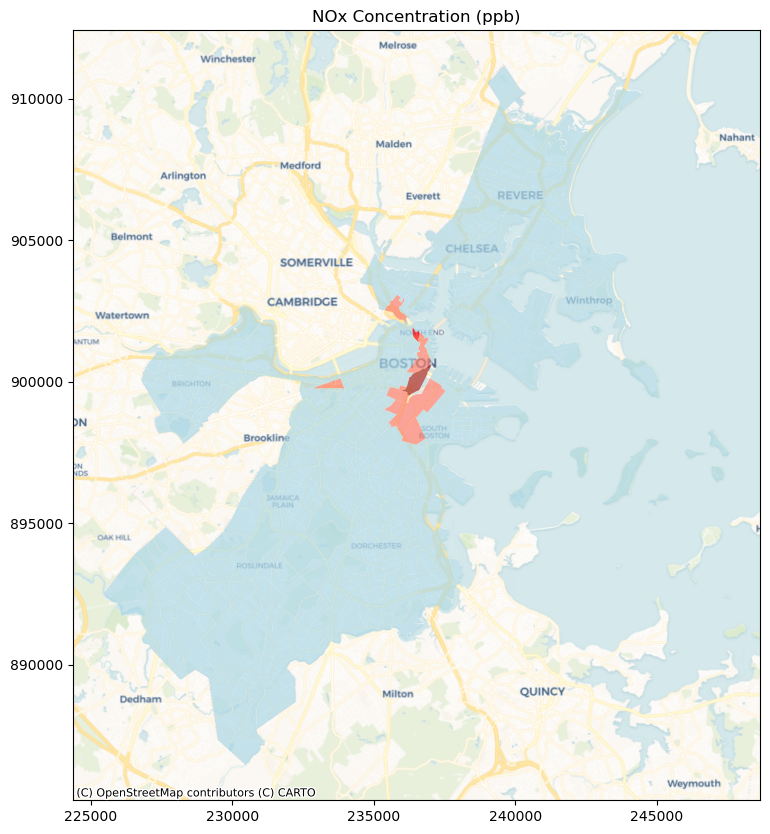

In [19]:
# NOx Concentrations (ppb) Visualization

# creating a colormap with a color for each category
colors = ['lightblue','salmon','red','brown']
cmap = ListedColormap(colors)

# plotting the map using the new colors and setting the title
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf_boston.plot(column='Pollution Category', cmap=cmap, ax=ax, alpha=0.7)
ax.set_title('NOx Concentration (ppb)')

# adding basemap using contextily
cx.add_basemap(ax=ax, crs=merged_gdf_boston.crs, source=cx.providers.CartoDB.Voyager)

# saving the plot and displaying it here
plt.savefig('pollution_Boston.png', bbox_inches='tight')
plt.show()

#### Statistical Analysis ####

In [20]:
# summary statistics for the numeric columns of the dataframe
merged_gdf.describe()

,TOTAL_CONC,D3B,D4A,D2B_E8MIXA,D2A_EPHHM,NatWalkInd,Walkability Category,Pollution Category
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,2.684947,173.927001,-5042.827615,0.545899,0.476082,14.420493,2.319022,0.013119
std,4.190311,116.588464,22620.707524,0.194140,0.219837,2.749661,0.646416,0.133145
min,0.032483,0.000000,-99999.000000,-0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.778638,100.613012,174.350000,0.428219,0.296619,13.000000,2.000000,0.000000
50%,1.380809,154.761304,273.590000,0.577541,0.475452,14.666667,2.000000,0.000000
75%,2.725005,220.353077,419.770000,0.695627,0.655023,16.333333,3.000000,0.000000
max,73.663200,1355.438608,1190.910000,0.886860,0.996975,19.833333,3.000000,3.000000


In [21]:
# for some of the entries in 'D4A' had -99999 values if the distance from the population-weighted centroids to transit
# stops is more than three-quarter miles. These rows are dropped since they are invalid entries
merged_gdf = merged_gdf[merged_gdf['D4A'] != -99999]

In [22]:
# calculating the centroid for the CBGs adding them as new columns in the dataframe
centroid = merged_gdf.geometry.centroid
merged_gdf['centroid_latitude'] = centroid.y
merged_gdf['centroid_longitude'] = centroid.x
merged_gdf.head()

,GEOID10,TOTAL_CONC,COUNTYFP10,geometry,D3B,D4A,D2B_E8MIXA,D2A_EPHHM,NatWalkInd,Walkability Category,Pollution Category,centroid_latitude,centroid_longitude
0,250092011001,0.252740,009,"POLYGON ((246381.267 911958.018, 246415.606 91...",150.103295,258.84,0.329382,0.509057,14.333333,2,0,910032.617130,246439.711492
1,250092011002,0.186181,009,"MULTIPOLYGON (((247431.927 908949.847, 247442....",109.759819,240.06,0.650444,0.245113,14.333333,2,0,908426.631630,248168.132864
2,250092011003,0.530704,009,"MULTIPOLYGON (((247128.396 908760.186, 247155....",92.582777,205.19,0.351801,0.410253,13.166667,2,0,908234.640848,247953.592463
3,250092011004,0.231062,009,"POLYGON ((246901.582 908651.584, 246900.118 90...",105.458572,205.19,0.552603,0.214093,13.500000,2,0,908203.593366,246779.040610
4,250092021011,0.152737,009,"POLYGON ((249381.471 915086.470, 249386.783 91...",79.235448,535.11,0.510901,0.720518,13.333333,2,0,914271.725360,249116.525854


In [23]:
# calculating the spatial weight matrix that connects every observation to its k nearest neighbors based on the centroid
# latitudes and longitudes
w = libpysal.weights.KNN.from_array(merged_gdf[['centroid_longitude', 'centroid_latitude']].values)
w.transform = 'R'

**Spatial Regression** <br>
**Dependent Variable:** NOx Concentration (ppb) <br>
**Independent Variable:** National Walkability Index

In [24]:
# defining the X and Y variables for the spatial regression
X = merged_gdf[['NatWalkInd']]
Y = merged_gdf[['TOTAL_CONC']]

**Baseline Model** <br>
$
Y = \alpha + \beta X_i + \epsilon_i
$

In [25]:
m1 = spreg.OLS(x = X.values, y = Y.values, w=w, spat_diag=True,
               name_x = X.columns.tolist(), name_y = Y.columns.tolist()) 

In [26]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['TOTAL_CONC']                Number of Observations:        1587
Mean dependent var  :      2.6940                Number of Variables   :           2
S.D. dependent var  :      4.1921                Degrees of Freedom    :        1585
R-squared           :      0.0241
Adjusted R-squared  :      0.0234
Sum squared residual:   27201.355                F-statistic           :     39.0653
Sigma-square        :      17.162                Prob(F-statistic)     :   5.257e-10
S.E. of regression  :       4.143                Log likelihood        :   -4506.523
Sigma-square ML     :      17.140                Akaike info criterion :    9017.047
S.E of regression ML:      4.1401                Schwarz criterion     :    9027.786

---------------------------------------------------------------------------

**Spatially lagged exogenous regressors** <br>
$
Y = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i
$

In [27]:
# introducing National Walkability Index as saptially lag variable
X_wx = X.assign(w_NatWalkInd = libpysal.weights.lag_spatial(w, X['NatWalkInd'].values))
X_wx.head()

,NatWalkInd,w_NatWalkInd
0,14.333333,14.916667
1,14.333333,13.333333
2,13.166667,13.916667
3,13.500000,13.750000
4,13.333333,15.666667


In [28]:
m2 = spreg.OLS(x = X_wx.values, y = Y.values, w=w, spat_diag=True,
               name_x = X_wx.columns.tolist(), name_y = Y.columns.tolist()) 

In [29]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['TOTAL_CONC']                Number of Observations:        1587
Mean dependent var  :      2.6940                Number of Variables   :           3
S.D. dependent var  :      4.1921                Degrees of Freedom    :        1584
R-squared           :      0.0352
Adjusted R-squared  :      0.0339
Sum squared residual:   26891.656                F-statistic           :     28.8663
Sigma-square        :      16.977                Prob(F-statistic)     :    4.86e-13
S.E. of regression  :       4.120                Log likelihood        :   -4497.437
Sigma-square ML     :      16.945                Akaike info criterion :    9000.874
S.E of regression ML:      4.1164                Schwarz criterion     :    9016.983

---------------------------------------------------------------------------

**Spatially lagged endogenous regressors** <br>
$
Y = \alpha + \lambda \sum_j w_{ij} (Y) + \beta X_i + \epsilon_i
$

In [30]:
m3 = spreg.GM_Lag(x = X.values, y = Y.values, w=w, spat_diag=True,
               name_x = X.columns.tolist(), name_y = 'TOTAL_CONC') 

In [31]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  TOTAL_CONC                Number of Observations:        1587
Mean dependent var  :      2.6940                Number of Variables   :           3
S.D. dependent var  :      4.1921                Degrees of Freedom    :        1584
Pseudo R-squared    :      0.4105
Spatial Pseudo R-squared:  0.0454

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -1.0395492       0.5752752      -1.8070468       0.0707550
          NatWalkInd       0.1098082       0.0511315       2.1475659       0.0317483
        W_TOTAL_CONC       0.8469829       0.1548633       

**Spatial Regression** <br>
**Dependent Variable:** <br>
NOx Concentration (ppb) <br>
**Independent Variables:** <br>
Intersection Density (D3B) <br>
Proximity to transit stops (D4A) <br>
Employment Mix (D2B_E8MIXA) <br>
Employment and household mix (D2A_EPHHM) <br>

In [32]:
# defining the X and Y variables for the spatial regression
X = merged_gdf[['D3B', 'D4A', 'D2B_E8MIXA', 'D2A_EPHHM']]
Y = merged_gdf[['TOTAL_CONC']]

**Baseline Model** <br>
$
Y = \alpha + \beta X_i + \epsilon_i
$

In [33]:
m1 = spreg.OLS(x = X.values, y = Y.values, w=w, spat_diag=True,
               name_x = X.columns.tolist(), name_y = Y.columns.tolist()) 

In [34]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['TOTAL_CONC']                Number of Observations:        1587
Mean dependent var  :      2.6940                Number of Variables   :           5
S.D. dependent var  :      4.1921                Degrees of Freedom    :        1582
R-squared           :      0.0714
Adjusted R-squared  :      0.0691
Sum squared residual:   25881.127                F-statistic           :     30.4200
Sigma-square        :      16.360                Prob(F-statistic)     :   2.014e-24
S.E. of regression  :       4.045                Log likelihood        :   -4467.044
Sigma-square ML     :      16.308                Akaike info criterion :    8944.089
S.E of regression ML:      4.0383                Schwarz criterion     :    8970.937

---------------------------------------------------------------------------

In [35]:
# introducing D4A as saptially lag variable
X_wx = X.assign(w_d4a = libpysal.weights.lag_spatial(w, X['D4A'].values))
X_wx.head()

,D3B,D4A,D2B_E8MIXA,D2A_EPHHM,w_d4a
0,150.103295,258.84,0.329382,0.509057,239.390
1,109.759819,240.06,0.650444,0.245113,205.190
2,92.582777,205.19,0.351801,0.410253,222.625
3,105.458572,205.19,0.552603,0.214093,222.625
4,79.235448,535.11,0.510901,0.720518,595.455


**Spatially lagged exogenous regressors** <br>
$
Y = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i
$

In [36]:
m2 = spreg.OLS(x = X_wx.values, y = Y.values, w=w, spat_diag=True,
               name_x = X_wx.columns.tolist(), name_y = Y.columns.tolist()) 

In [37]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['TOTAL_CONC']                Number of Observations:        1587
Mean dependent var  :      2.6940                Number of Variables   :           6
S.D. dependent var  :      4.1921                Degrees of Freedom    :        1581
R-squared           :      0.0740
Adjusted R-squared  :      0.0711
Sum squared residual:   25809.170                F-statistic           :     25.2700
Sigma-square        :      16.325                Prob(F-statistic)     :    1.39e-24
S.E. of regression  :       4.040                Log likelihood        :   -4464.835
Sigma-square ML     :      16.263                Akaike info criterion :    8941.670
S.E of regression ML:      4.0327                Schwarz criterion     :    8973.888

---------------------------------------------------------------------------

**Spatially lagged endogenous regressors** <br>
$
Y = \alpha + \lambda \sum_j w_{ij} (Y) + \beta X_i + \epsilon_i
$

In [38]:
m3 = spreg.GM_Lag(x = X.values, y = Y.values, w=w, spat_diag=True,
               name_x = X.columns.tolist(), name_y = 'TOTAL_CONC') 

In [39]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  TOTAL_CONC                Number of Observations:        1587
Mean dependent var  :      2.6940                Number of Variables   :           6
S.D. dependent var  :      4.1921                Degrees of Freedom    :        1581
Pseudo R-squared    :      0.4217
Spatial Pseudo R-squared:  0.0551

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.2186640       0.3556468      -0.6148347       0.5386639
                 D3B      -0.0006573       0.0008811      -0.7459398       0.4557038
                 D4A      -0.0006146       0.0003709      -